In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Load the data
df = pd.read_csv('../data/processed/eth_regression_data.csv')

# Convert week_start to datetime
df['week_start'] = pd.to_datetime(df['week_start'])
df = df.sort_values('week_start').reset_index(drop=True)

print("Dataset shape:", df.shape)
print("Date range:", df['week_start'].min(), "to", df['week_start'].max())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (148, 28)
Date range: 2022-09-26 00:00:00 to 2025-07-21 00:00:00

First few rows:
  week_start  weekly_vol  weekly_mean_return  weekly_abs_return  trading_days  \
0 2022-09-26    0.018016           -0.001844           0.012618             7   
1 2022-10-03    0.020175            0.005313           0.015060             7   
2 2022-10-10    0.016986           -0.001538           0.014041             7   
3 2022-10-17    0.020400            0.006370           0.017103             7   
4 2022-10-24    0.046994            0.023219           0.042081             7   

   weekly_vol_annualized  market_weekly_vol  market_weekly_vol_annualized  \
0               0.129916           0.013440                      0.096920   
1               0.145481           0.018831                      0.135792   
2               0.122491           0.012264                      0.088438   
3               0.147105           0.015430                      0.111268   
4               0.338877       

In [2]:
# =============================================================================
# STEP 1: STATIONARITY TESTING
# =============================================================================

# Test key variables for stationarity
variables_to_test = {
    'weekly_vol_annualized': 'ETH Volatility (Annualized)',
    'market_weekly_vol_annualized': 'Market Volatility (Annualized)',
    'top1_centrality': 'Top 1% Centrality',
    'top3_centrality': 'Top 3% Centrality', 
    'top5_centrality': 'Top 5% Centrality',
    'top10_centrality': 'Top 10% Centrality',
    'hhi': 'Herfindahl-Hirschman Index',
    'gini': 'Gini Coefficient'
}

stationarity_results = {}

print("\n" + "="*80)
print("STATIONARITY TESTING")
print("="*80)

for var, name in variables_to_test.items():
    print(f"\n=== Testing {name} ({var}) ===")
    
    series = df[var].dropna()
    
    # ADF Test (H0: non-stationary, i.e., has unit root)
    adf_result = adfuller(series, autolag='AIC')
    print(f"ADF Test:")
    print(f"  Test Statistic: {adf_result[0]:.4f}")
    print(f"  p-value: {adf_result[1]:.4f}")
    print(f"  Critical Values (1%, 5%, 10%): {adf_result[4]}")
    adf_stationary = adf_result[1] < 0.05
    print(f"  Stationary (ADF): {'Yes' if adf_stationary else 'No'}")
    
    # KPSS Test (H0: stationary around trend)
    try:
        kpss_result = kpss(series, regression='c')
        print(f"KPSS Test:")
        print(f"  Test Statistic: {kpss_result[0]:.4f}")
        print(f"  p-value: {kpss_result[1]:.4f}")
        print(f"  Critical Values (10%, 5%, 2.5%, 1%): {kpss_result[3]}")
        kpss_stationary = kpss_result[1] > 0.05
        print(f"  Stationary (KPSS): {'Yes' if kpss_stationary else 'No'}")
        
        # Combined conclusion
        if adf_stationary and kpss_stationary:
            conclusion = "STATIONARY"
        elif not adf_stationary and not kpss_stationary:
            conclusion = "NON-STATIONARY"
        else:
            conclusion = "INCONCLUSIVE - Consider first differencing"
        
    except Exception as e:
        print(f"  KPSS test failed: {e}")
        conclusion = "STATIONARY" if adf_stationary else "NON-STATIONARY"
    
    print(f"  Final Conclusion: {conclusion}")
    stationarity_results[var] = {
        'name': name,
        'adf_pvalue': adf_result[1],
        'adf_stationary': adf_stationary,
        'conclusion': conclusion
    }

# Summary of stationarity results
print("\n" + "="*50)
print("STATIONARITY SUMMARY")
print("="*50)
for var, result in stationarity_results.items():
    print(f"{result['name']}: {result['conclusion']} (ADF p-value: {result['adf_pvalue']:.4f})")



STATIONARITY TESTING

=== Testing ETH Volatility (Annualized) (weekly_vol_annualized) ===
ADF Test:
  Test Statistic: -3.6868
  p-value: 0.0043
  Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.4769274060112707), '5%': np.float64(-2.8819726324025625), '10%': np.float64(-2.577665408088415)}
  Stationary (ADF): Yes
KPSS Test:
  Test Statistic: 0.6414
  p-value: 0.0189
  Critical Values (10%, 5%, 2.5%, 1%): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  Stationary (KPSS): No
  Final Conclusion: INCONCLUSIVE - Consider first differencing

=== Testing Market Volatility (Annualized) (market_weekly_vol_annualized) ===
ADF Test:
  Test Statistic: -10.2974
  p-value: 0.0000
  Critical Values (1%, 5%, 10%): {'1%': np.float64(-3.4756368462466662), '5%': np.float64(-2.8814104466172608), '10%': np.float64(-2.5773652982553568)}
  Stationary (ADF): Yes
KPSS Test:
  Test Statistic: 0.1511
  p-value: 0.1000
  Critical Values (10%, 5%, 2.5%, 1%): {'10%': 0.347, '5%': 0.463, '2.5%': 0.574

In [3]:
# =============================================================================
# STEP 2: FIRST DIFFERENCING (if needed)
# =============================================================================

# Create first differences for non-stationary variables
print("\n" + "="*80)
print("CREATING FIRST DIFFERENCES FOR NON-STATIONARY VARIABLES")
print("="*80)

non_stationary_vars = [var for var, result in stationarity_results.items() 
                      if result['conclusion'] in ['NON-STATIONARY', 'INCONCLUSIVE - Consider first differencing']]

print(f"Variables that may need differencing: {non_stationary_vars}")

# Create differenced versions
df_analysis = df.copy()
differenced_vars = {}

for var in non_stationary_vars:
    diff_var = f"{var}_diff"
    df_analysis[diff_var] = df_analysis[var].diff()
    differenced_vars[var] = diff_var
    
    # Test stationarity of differenced series
    print(f"\nTesting stationarity of differenced {var}:")
    series_diff = df_analysis[diff_var].dropna()
    adf_result = adfuller(series_diff, autolag='AIC')
    print(f"  ADF p-value: {adf_result[1]:.4f}")
    print(f"  Stationary: {'Yes' if adf_result[1] < 0.05 else 'No'}")


CREATING FIRST DIFFERENCES FOR NON-STATIONARY VARIABLES
Variables that may need differencing: ['weekly_vol_annualized', 'top1_centrality', 'top3_centrality', 'top5_centrality', 'top10_centrality', 'hhi', 'gini']

Testing stationarity of differenced weekly_vol_annualized:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top1_centrality:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top3_centrality:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced top5_centrality:
  ADF p-value: 0.0002
  Stationary: Yes

Testing stationarity of differenced top10_centrality:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced hhi:
  ADF p-value: 0.0000
  Stationary: Yes

Testing stationarity of differenced gini:
  ADF p-value: 0.0003
  Stationary: Yes



TIME SERIES VISUALIZATION


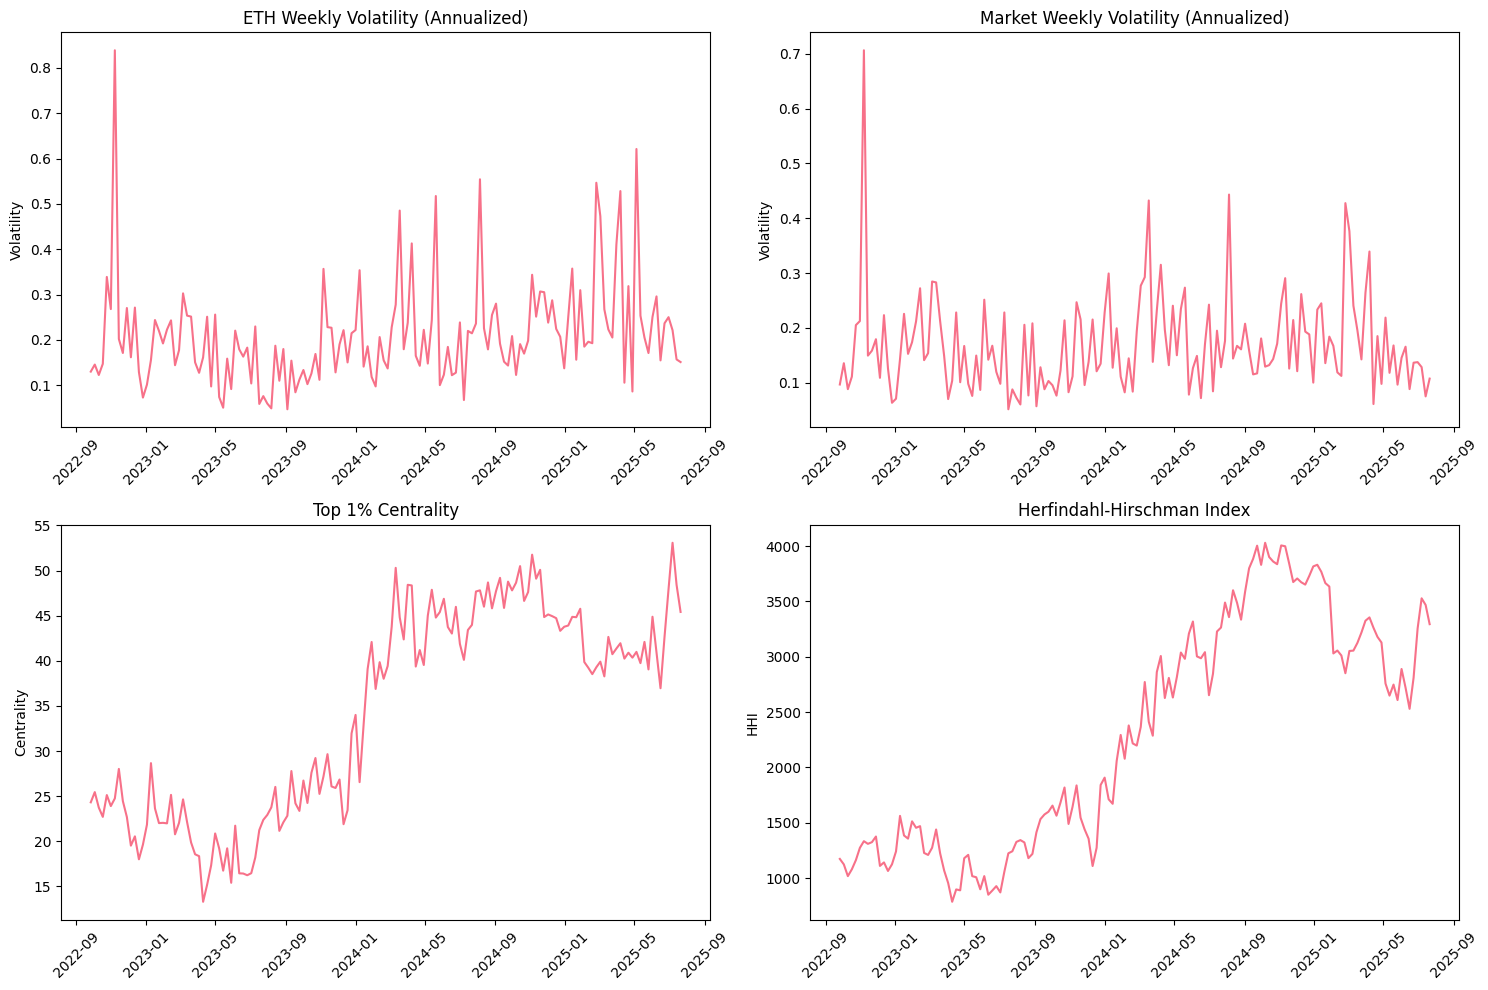

In [4]:
# =============================================================================
# STEP 3: VISUALIZATION OF TIME SERIES
# =============================================================================

print("\n" + "="*80)
print("TIME SERIES VISUALIZATION")
print("="*80)

# Plot volatility measures
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ETH Volatility
axes[0,0].plot(df['week_start'], df['weekly_vol_annualized'])
axes[0,0].set_title('ETH Weekly Volatility (Annualized)')
axes[0,0].set_ylabel('Volatility')
axes[0,0].tick_params(axis='x', rotation=45)

# Market Volatility
axes[0,1].plot(df['week_start'], df['market_weekly_vol_annualized'])
axes[0,1].set_title('Market Weekly Volatility (Annualized)')
axes[0,1].set_ylabel('Volatility')
axes[0,1].tick_params(axis='x', rotation=45)

# Top 1% Centrality
axes[1,0].plot(df['week_start'], df['top1_centrality'])
axes[1,0].set_title('Top 1% Centrality')
axes[1,0].set_ylabel('Centrality')
axes[1,0].tick_params(axis='x', rotation=45)

# HHI
axes[1,1].plot(df['week_start'], df['hhi'])
axes[1,1].set_title('Herfindahl-Hirschman Index')
axes[1,1].set_ylabel('HHI')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# =============================================================================
# STEP 4: GRANGER CAUSALITY TESTS
# =============================================================================

print("\n" + "="*80)
print("GRANGER CAUSALITY TESTS")
print("="*80)

# Prepare data for Granger causality tests
# Use stationary versions of variables

# Select key variables for analysis (focusing on main relationships)
volatility_var = 'weekly_vol_annualized'
centrality_vars = ['top1_centrality', 'top3_centrality', 'top5_centrality', 'hhi', 'gini']

# Determine which variables to use (original or differenced)
def get_stationary_var(var_name, df_data):
    if stationarity_results[var_name]['conclusion'] == 'STATIONARY':
        return df_data[var_name].dropna()
    else:
        diff_var = f"{var_name}_diff"
        if diff_var in df_data.columns:
            return df_data[diff_var].dropna()
        else:
            return df_data[var_name].diff().dropna()

# Test optimal lag length first
max_lags = min(12, len(df) // 10)  # Rule of thumb: max lags = T/10, but cap at 12 for weekly data
print(f"Testing lag lengths up to {max_lags} weeks...")

# Prepare bivariate datasets for lag selection
vol_series = get_stationary_var(volatility_var, df_analysis)

# Test each centrality measure
granger_results = {}

for cent_var in centrality_vars:
    print(f"\n{'='*60}")
    print(f"TESTING: {variables_to_test[cent_var]} vs ETH Volatility")
    print(f"{'='*60}")
    
    cent_series = get_stationary_var(cent_var, df_analysis)
    
    # Align series (handle different lengths due to differencing)
    min_len = min(len(vol_series), len(cent_series))
    vol_aligned = vol_series.iloc[-min_len:].reset_index(drop=True)
    cent_aligned = cent_series.iloc[-min_len:].reset_index(drop=True)
    
    # Create bivariate dataset
    bivariate_data = pd.DataFrame({
        'volatility': vol_aligned,
        'centrality': cent_aligned
    }).dropna()
    
    print(f"Sample size for analysis: {len(bivariate_data)}")
    
    if len(bivariate_data) < 20:
        print(f"Insufficient data for {cent_var}, skipping...")
        continue
    
    # Determine optimal lag length using AIC/BIC
    try:
        # Test different lag lengths
        aic_scores = []
        bic_scores = []
        test_lags = range(1, min(max_lags + 1, len(bivariate_data) // 4))
        
        for lag in test_lags:
            try:
                model = VAR(bivariate_data)
                fitted_model = model.fit(lag)
                aic_scores.append(fitted_model.aic)
                bic_scores.append(fitted_model.bic)
            except:
                aic_scores.append(np.inf)
                bic_scores.append(np.inf)
        
        if aic_scores:
            optimal_lag_aic = test_lags[np.argmin(aic_scores)]
            optimal_lag_bic = test_lags[np.argmin(bic_scores)]
            optimal_lag = optimal_lag_bic  # Use BIC as it's more conservative
            print(f"Optimal lag length (BIC): {optimal_lag}")
        else:
            optimal_lag = 2  # Default
            print(f"Using default lag length: {optimal_lag}")
        
    except Exception as e:
        print(f"Error in lag selection: {e}")
        optimal_lag = 2
        print(f"Using default lag length: {optimal_lag}")
    
    # Perform Granger causality tests
    try:
        # Test if centrality Granger causes volatility
        print(f"\n--- Testing if {variables_to_test[cent_var]} Granger-causes Volatility ---")
        gc_result_1 = grangercausalitytests(bivariate_data[['volatility', 'centrality']], 
                                           maxlag=optimal_lag, verbose=False)
        
        # Test if volatility Granger causes centrality  
        print(f"\n--- Testing if Volatility Granger-causes {variables_to_test[cent_var]} ---")
        gc_result_2 = grangercausalitytests(bivariate_data[['centrality', 'volatility']], 
                                           maxlag=optimal_lag, verbose=False)
        
        # Extract p-values for each lag
        gc_pvals_1 = {}
        gc_pvals_2 = {}
        
        for lag in range(1, optimal_lag + 1):
            # Centrality -> Volatility
            gc_pvals_1[lag] = gc_result_1[lag][0]['ssr_ftest'][1]  # F-test p-value
            
            # Volatility -> Centrality  
            gc_pvals_2[lag] = gc_result_2[lag][0]['ssr_ftest'][1]  # F-test p-value
        
        # Store results
        granger_results[cent_var] = {
            'variable_name': variables_to_test[cent_var],
            'optimal_lag': optimal_lag,
            'centrality_causes_volatility': gc_pvals_1,
            'volatility_causes_centrality': gc_pvals_2,
            'sample_size': len(bivariate_data)
        }
        
        # Print results
        print(f"\nGranger Causality Results for {variables_to_test[cent_var]}:")
        print(f"Sample size: {len(bivariate_data)}")
        print(f"Optimal lag: {optimal_lag}")
        
        for lag in range(1, optimal_lag + 1):
            print(f"\nLag {lag}:")
            print(f"  {variables_to_test[cent_var]} → Volatility: p-value = {gc_pvals_1[lag]:.4f}")
            print(f"  Volatility → {variables_to_test[cent_var]}: p-value = {gc_pvals_2[lag]:.4f}")
            
            if gc_pvals_1[lag] < 0.05:
                print(f"  *** {variables_to_test[cent_var]} significantly Granger-causes Volatility at 5% level")
            if gc_pvals_2[lag] < 0.05:
                print(f"  *** Volatility significantly Granger-causes {variables_to_test[cent_var]} at 5% level")
                
    except Exception as e:
        print(f"Error in Granger causality test for {cent_var}: {e}")
        continue